# **Data Preparation**
Copy ML pipeline functions from prior chapter

In [ ]:
def import_data(path, messages=True):
  import pandas as pd
  df = pd.read_csv(path)
  if messages: print(df.shape)
  return df

def bin_groups(df, features=[], cutoff=0.05, replace_with='Other', messages=True):
  import pandas as pd
  if len(features) == 0: features = df.columns
  for feat in features:
    if feat in df.columns:  # Make sure they don't accidentally enter a feature name that doesn't exist
      if not pd.api.types.is_numeric_dtype(df[feat]):
        other_list = df[feat].value_counts()[df[feat].value_counts() / df.shape[0] < cutoff].index
        if len(other_list) > 0:
          df.loc[df[feat].isin(other_list), feat] = replace_with
          if messages and len(other_list) > 0: print(f'{feat} has been binned by setting {other_list.values} to {replace_with}')
    else:
      if messages: print(f'{feat} not found in the DataFrame provided. No binning performed')
  return df

def missing_drop(df, label, row_thresh=0.7, col_thresh=0.9, drop_all=False):
  df.dropna(axis='rows', subset=[label], inplace=True)
  df.dropna(axis='columns', thresh=1, inplace=True)
  df.dropna(axis='rows', thresh=1, inplace=True)
  df.dropna(axis='columns', thresh=round(df.shape[0] * row_thresh), inplace=True)
  df.dropna(axis='rows', thresh=round(df.shape[1] * col_thresh), inplace=True)
  if drop_all: df.dropna(axis='rows', inplace=True)
  return df

def Xandy(df, label):
  import pandas as pd
  y = df[label]
  X = df.drop(columns=[label])
  return X, y

def dummy_code(X):
  import pandas as pd
  X = pd.get_dummies(X, drop_first=True)
  return X

def minmax(X):
  import pandas as pd
  from sklearn.preprocessing import MinMaxScaler
  X = pd.DataFrame(MinMaxScaler().fit_transform(X.copy()), columns=X.columns, index=X.index)
  return X

def impute_KNN(df, label, neighbors=5):
  from sklearn.impute import KNNImputer
  import pandas as pd
  X, y = Xandy(df, label)
  X = dummy_code(X.copy())
  X = minmax(X.copy())
  imp = KNNImputer(n_neighbors=neighbors, weights="uniform")
  X = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)
  return X.merge(y, left_index=True, right_index=True)

def fit_cv_regression(df, k, label, repeat=True, algorithm='ensemble', random_state=1, messages=True):
  from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
  import pandas as pd
  from numpy import mean
  X, y = Xandy(df, label)
  X = dummy_code(X)
  if repeat:
    cv = RepeatedKFold(n_splits=k, n_repeats=5, random_state=random_state)
  else:
    cv = KFold(n_splits=k, random_state=random_state, shuffle=True)
  if algorithm == 'linear':
    from sklearn.linear_model import Ridge, LassoLars
    model1 = Ridge(random_state=random_state)
    model2 = LassoLars(random_state=random_state)
    score1 = mean(cross_val_score(model1, X, y, scoring='r2', cv=cv, n_jobs=-1))
    score2 = mean(cross_val_score(model2, X, y, scoring='r2', cv=cv, n_jobs=-1))
  elif algorithm == 'ensemble':
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
    model1 = RandomForestRegressor(random_state=random_state)
    model2 = GradientBoostingRegressor(random_state=random_state)
    score1 = mean(cross_val_score(model1, X, y, scoring='r2', cv=cv, n_jobs=-1))
    score2 = mean(cross_val_score(model2, X, y, scoring='r2', cv=cv, n_jobs=-1))
  else:
    from sklearn.neural_network import MLPRegressor
    from sklearn.neighbors import KNeighborsRegressor
    model1 = MLPRegressor(random_state=random_state, max_iter=10000)
    model2 = KNeighborsRegressor()
    score1 = mean(cross_val_score(model1, X, y, scoring='r2', cv=cv, n_jobs=-1))
    score2 = mean(cross_val_score(model2, X, y, scoring='r2', cv=cv, n_jobs=-1))
  if messages:
    print('R2', '{: <25}'.format(type(model1).__name__), round(score1, 4))
    print('R2', '{: <25}'.format(type(model2).__name__), round(score2, 4))
  if score1 > score2:
    return model1.fit(X, y)
  else:
    return model2.fit(X, y)

In [ ]:
# Don't forget to mount Google Drive if you need it:
from google.colab import drive
drive.mount('/content/drive')

# Setting the label here since it is used in multiple function calls
label = 'SalePrice'

# Import the data
df = import_data('/content/drive/MyDrive/Colab Notebooks/data/housing.csv', messages=False)

# Clean/prepare the data
df = bin_groups(df, messages=False)
df = missing_drop(df, label)
df = impute_KNN(df, label)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Feature Importance**

## Bivariate feature importance

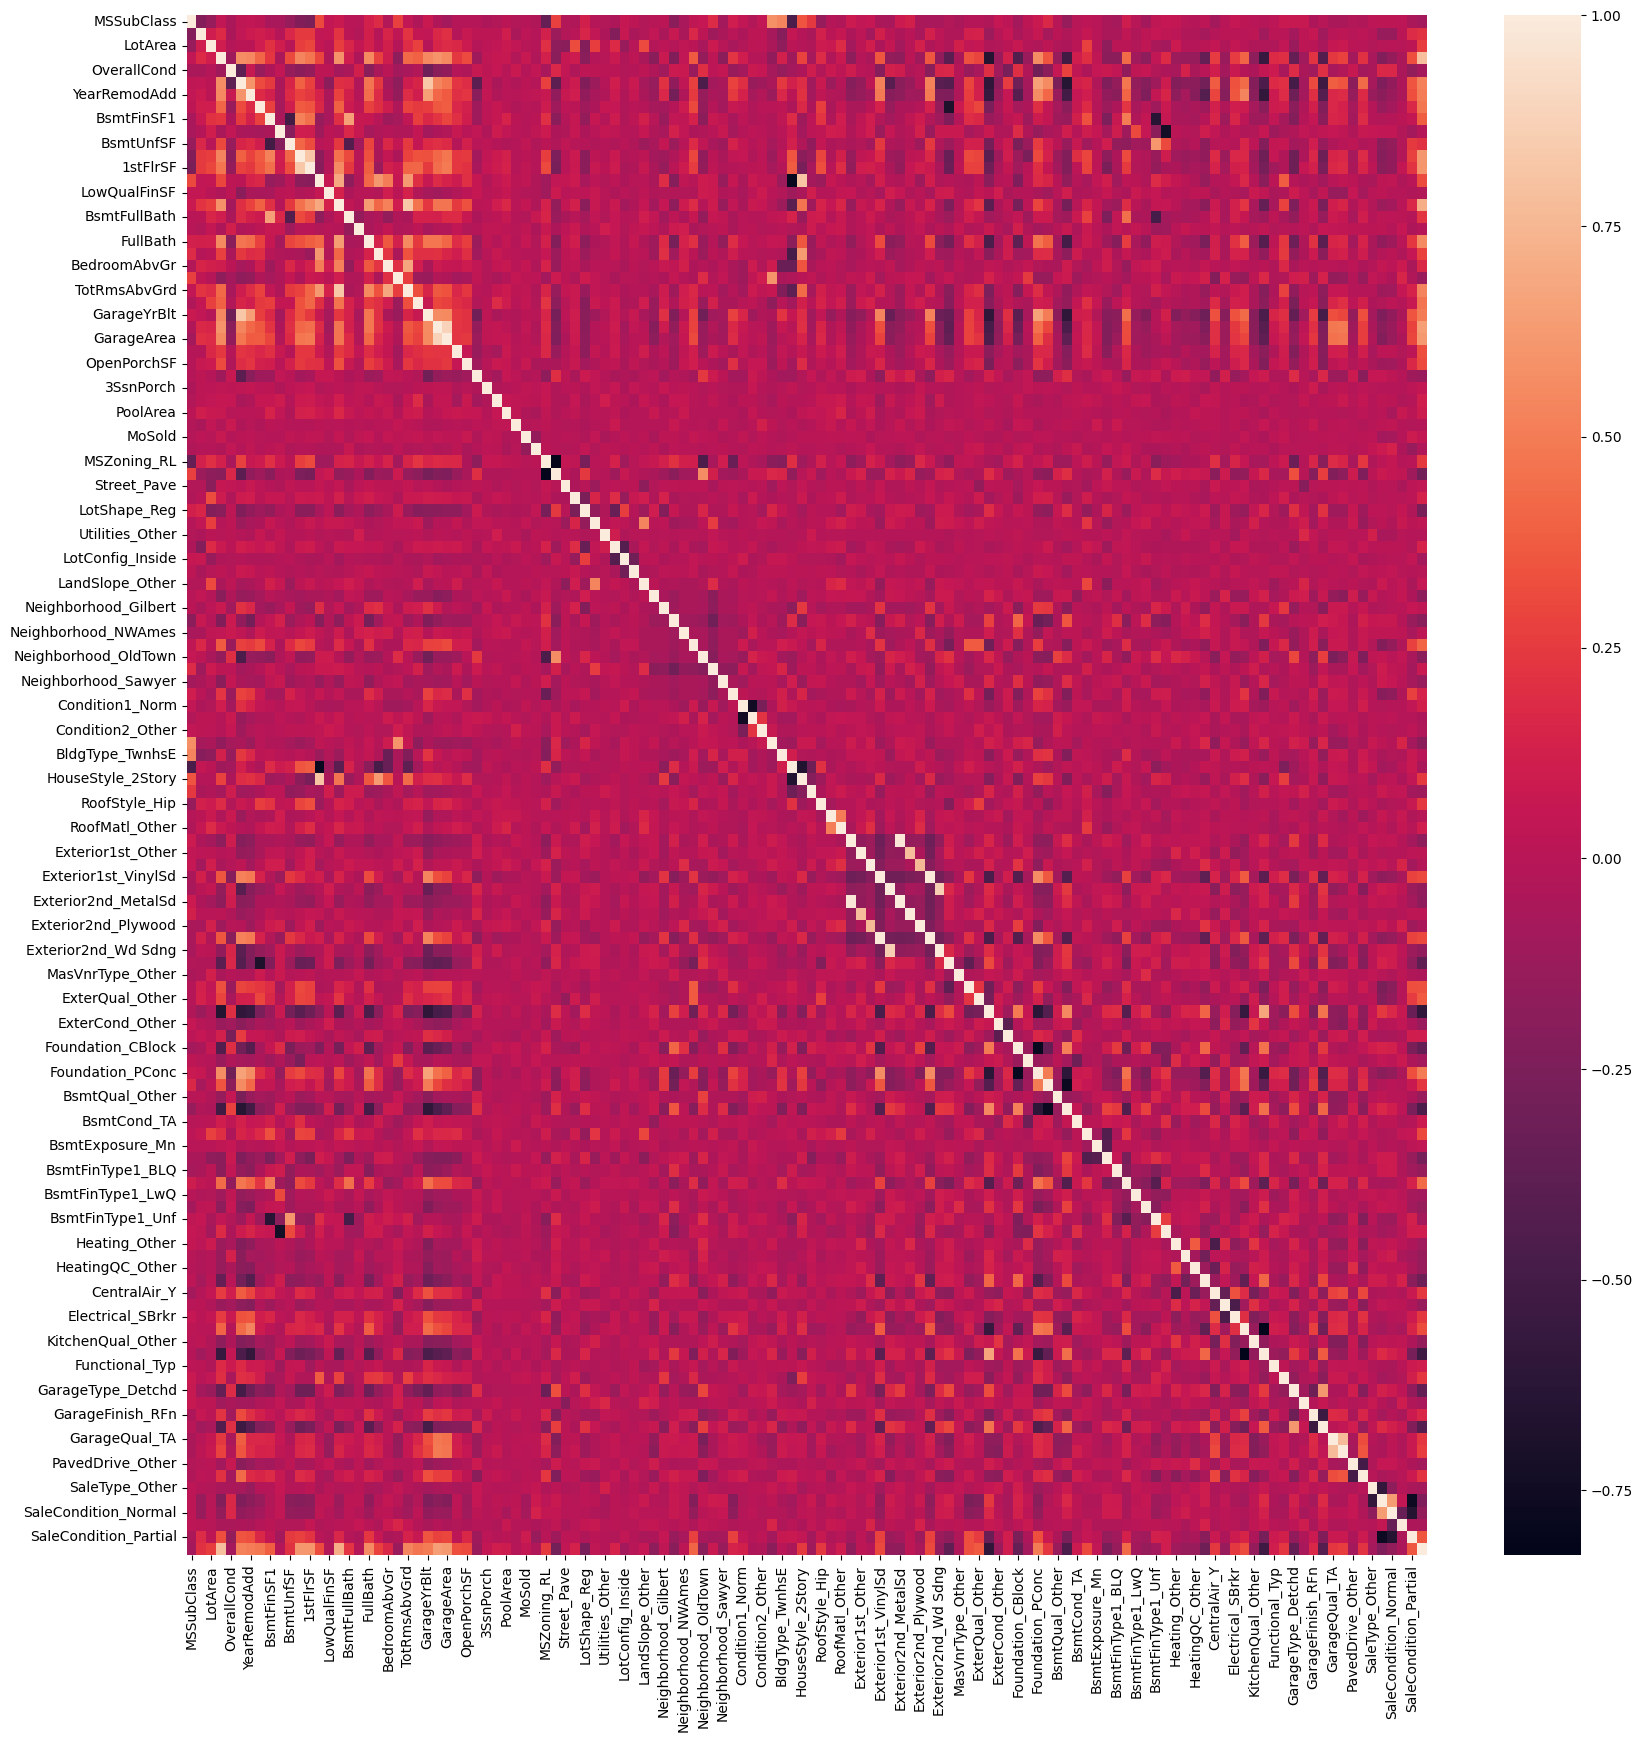

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(20, 20))
sns.heatmap(df.corr())
plt.show()

Bivariate Relationship Function

In [ ]:
def bivariate(df, label, roundto=4):
  import pandas as pd, numpy as np
  from scipy import stats

  output_df = pd.DataFrame(columns=['unique', 'sign', 'r', 'ρ', 'τ'])

  for feature in df.columns:
    if feature != label: # Don't need the relationship fo the label with itself
      df_temp = df[[feature, label]]      # Make a version of the DataFrame with only the feature and label
      df_temp = df_temp.dropna()          # Drop missing rows from that DataFrame
      unique = df_temp[feature].nunique() # Knowing the n unique values will help determine which corr metrics to use

      r, p = stats.pearsonr(df_temp[feature], df_temp[label])
      rho, rp = stats.spearmanr(df_temp[feature], df_temp[label])
      tau, tp = stats.kendalltau(df_temp[feature], df_temp[label])

      if r < 0: sign = '-'  # To compare feature importance, we must convert all negative r to positive
      else:     sign = '+'  # Therefore, let's make another column to inidcate it's sign

      # Insert a record for this feature into output_df
      output_df.loc[feature] = [unique, sign, round(abs(r), roundto),  round(abs(rho), roundto),
                                round(abs(tau), roundto)]
  return output_df.sort_values(by=['r'], ascending=False)

# Make a DataFrame to keep track of feature importance based on each technique we learn

df_importance = bivariate(df, 'SalePrice')
df_importance

,unique,sign,r,ρ,τ
OverallQual,10,+,0.78980,0.80800,0.66770
TotalSF,859,+,0.70770,0.73120,0.54410
GarageCars,5,+,0.63710,0.68650,0.56820
GarageArea,441,+,0.61970,0.64490,0.47400
TotalBsmtSF,721,+,0.60980,0.59750,0.43050
...,...,...,...,...,...
MiscVal,20,-,0.01430,0.05850,0.04750
BsmtFinSF2,144,-,0.01320,0.04190,0.03320
RoofStyle_Other,2,-,0.00600,0.01240,0.01010
LotConfig_Other,2,-,0.00260,0.01480,0.01210


## **Multivariate feature importance**

### Linear Models: Coefficients

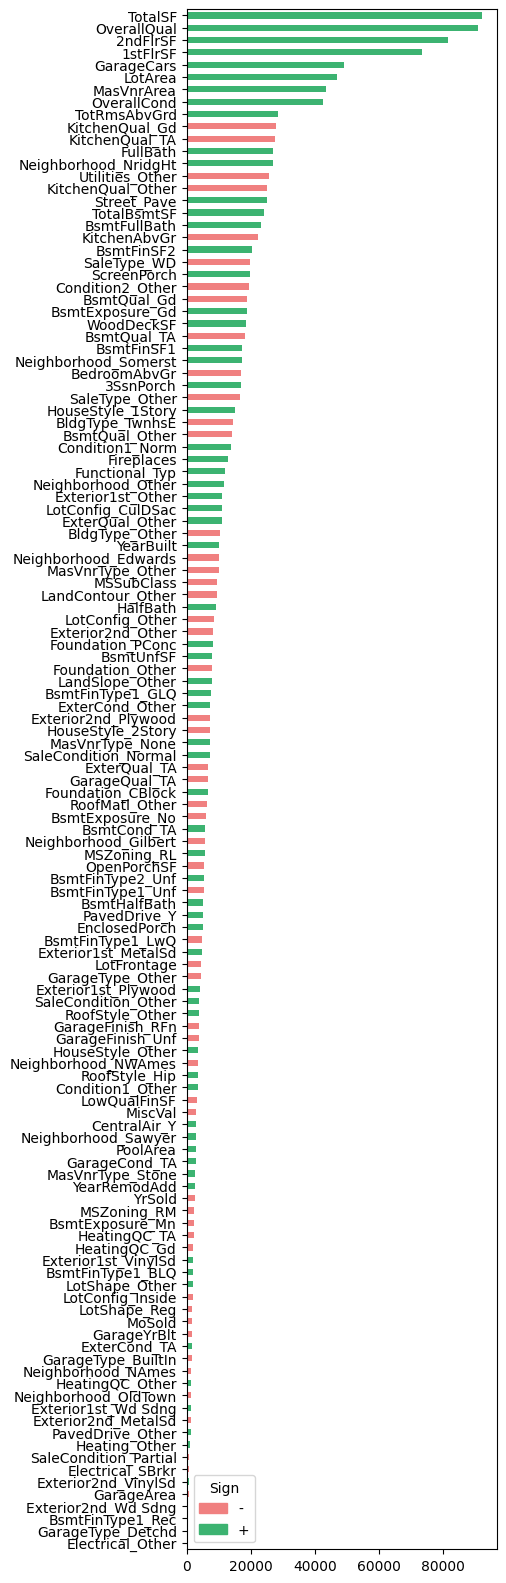

,unique,sign,r,ρ,τ,Coefficients,sign_coef
OverallQual,10,+,0.78980,0.80800,0.66770,91066.91161,+
TotalSF,859,+,0.70770,0.73120,0.54410,92188.95812,+
GarageCars,5,+,0.63710,0.68650,0.56820,49046.00759,+
GarageArea,441,+,0.61970,0.64490,0.47400,726.59047,-
TotalBsmtSF,721,+,0.60980,0.59750,0.43050,24070.16504,+
...,...,...,...,...,...,...,...
MiscVal,20,-,0.01430,0.05850,0.04750,3040.97207,-
BsmtFinSF2,144,-,0.01320,0.04190,0.03320,20526.07397,+
RoofStyle_Other,2,-,0.00600,0.01240,0.01010,3883.34884,+
LotConfig_Other,2,-,0.00260,0.01480,0.01210,8618.14413,-


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

# Create a model based on the linear algorithm with the highest fit metric
model = fit_cv_regression(df, 10, label, algorithm='linear', messages=False)

# Store the coefficients of that model in a new DataFrame
df_coef = pd.DataFrame({'Coefficients':model.coef_}, index=model.feature_names_in_)
df_coef['sign'] = '+'           # Add a column to indicate sign; default to positive
for coef in df_coef.itertuples(): # Set each coefficient to the abs() and store the sign
  if coef[1] < 0:                 # If it's negative, change to positive and store sign
    df_coef.at[coef[0], 'sign'] = '-'
    df_coef.at[coef[0], 'Coefficients'] = coef[1] * -1

df_coef.sort_values(by=['Coefficients'], inplace=True)  # Sort the results for the image
plt.figure(figsize=(4,20))                              # Set the size of the image

# Plot the coefficients in a bar chart separately for positive vs negative with diff colors
colors = {'+': 'mediumseagreen', '-': 'lightcoral'}
df_coef['Coefficients'].plot(kind='barh', color=[colors[i] for i in df_coef['sign']])

# Create the plot legend
labels = df_coef['sign'].unique()
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels]
plt.legend(handles, labels, title="Sign")
plt.show()

# Store the coefficients in our df_importance table for later comparison
df_importance = df_importance.merge(df_coef, left_index=True, right_index=True, suffixes=('', '_coef'))
df_importance

### Tree Models: Feature Importance

In [ ]:
model = fit_cv_regression(df, 5, label, repeat=False, algorithm='ensemble')

R2 RandomForestRegressor     0.8634
R2 GradientBoostingRegressor 0.8844


In [ ]:
fi = pd.DataFrame(model.feature_importances_, columns=['FI'], index=model.feature_names_in_)
df_importance = df_importance.merge(fi, left_index=True, right_index=True)
df_importance.sort_values(by=['FI'], ascending=False, inplace=True)
df_importance

,unique,sign,r,ρ,τ,Coefficients,sign_coef,FI
OverallQual,10,+,0.78980,0.80800,0.66770,91066.91161,+,0.53274
TotalSF,859,+,0.70770,0.73120,0.54410,92188.95812,+,0.13856
TotalBsmtSF,721,+,0.60980,0.59750,0.43050,24070.16504,+,0.05429
GarageCars,5,+,0.63710,0.68650,0.56820,49046.00759,+,0.05108
BsmtFinSF1,637,+,0.38290,0.29580,0.21620,17363.04799,+,0.04038
...,...,...,...,...,...,...,...,...
HouseStyle_Other,2,-,0.10840,0.10860,0.08880,3716.22329,+,0.00000
BsmtFinType2_Unf,2,+,0.10460,0.11280,0.09220,5403.00081,+,0.00000
ExterCond_TA,2,+,0.10140,0.12030,0.09840,1628.93556,+,0.00000
PavedDrive_Other,2,-,0.08990,0.10540,0.08620,1262.98016,+,0.00000


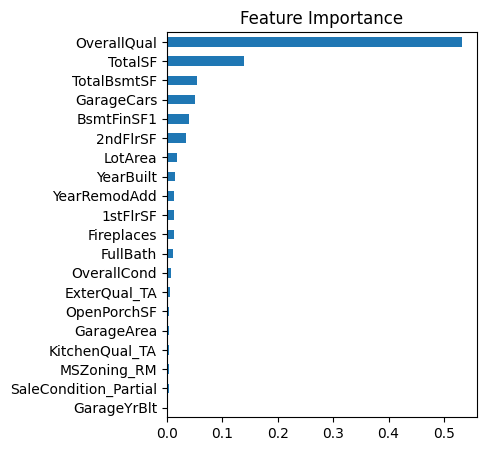

In [ ]:
df_pfi = pd.Series(model.feature_importances_, index=df.drop(columns=[label]).columns)
df_pfi.sort_values(ascending=True, inplace=True)
plt.figure(figsize=(4,5))
df_pfi.tail(20).plot(kind='barh', title = 'Feature Importance')
plt.show()

### Any Model: Permutation Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance
pd.set_option('display.max_rows', 10)

X, y = Xandy(df, label) # Required to have X and y for the PFI function
result = permutation_importance(model, X, y, n_repeats=10, scoring="r2", random_state=1, n_jobs=-1)
df_pfi = pd.DataFrame({'PFI':result.importances_mean, 'PFI std':result.importances_std},
                      index=model.feature_names_in_)
df_importance = df_importance.merge(df_pfi, left_index=True, right_index=True)
df_importance.sort_values(by=['PFI'], ascending=False, inplace=True)
df_importance

,unique,sign,r,ρ,τ,Coefficients,sign_coef,FI,PFI,PFI std
OverallQual,10,+,0.78980,0.80800,0.66770,91066.91161,+,0.53274,0.27249,0.01053
TotalSF,859,+,0.70770,0.73120,0.54410,92188.95812,+,0.13856,0.14074,0.00528
TotalBsmtSF,721,+,0.60980,0.59750,0.43050,24070.16504,+,0.05429,0.03019,0.00122
BsmtFinSF1,637,+,0.38290,0.29580,0.21620,17363.04799,+,0.04038,0.02888,0.00149
GarageCars,5,+,0.63710,0.68650,0.56820,49046.00759,+,0.05108,0.01812,0.00111
...,...,...,...,...,...,...,...,...,...,...
HeatingQC_TA,2,-,0.31400,0.36720,0.30030,2199.55820,-,0.00000,0.00000,0.00000
Exterior1st_VinylSd,2,+,0.30730,0.37510,0.30680,1983.70037,+,0.00000,0.00000,0.00000
BldgType_TwnhsE,2,+,0.00200,0.03650,0.02980,14530.10301,-,0.00000,0.00000,0.00000
RoofStyle_Hip,2,+,0.23910,0.15650,0.12800,3652.66950,+,0.00000,-0.00000,0.00000


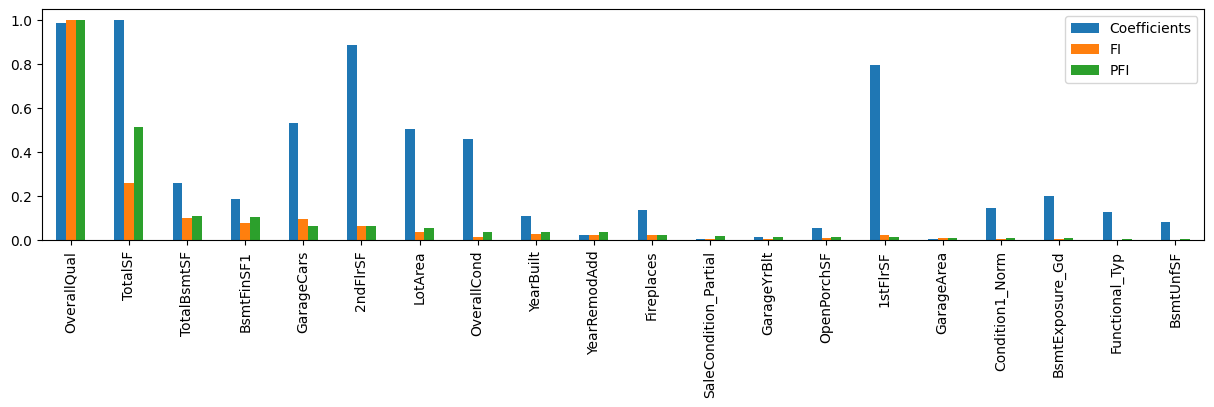

In [ ]:
# Create a noramlized version of the feature importance scores we want to see
df_imp_scaled = minmax(df_importance[['Coefficients', 'FI', 'PFI']])
df_imp_scaled.head(20).plot.bar(figsize=(15, 3))
plt.show()

# **Feature Selection**

## Bivariate Selection

### SelectKBest()
Select the top k features based on chosen bivariate metric: R2 or Chi2

In [ ]:
def fs_kbest(df, k=10, label=""):
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import r_regression
  import pandas as pd

  X, y = Xandy(df, label)

  # Select the top k features based on a given bivariate metric
  sel = SelectKBest(r_regression, k=k)
  sel.fit_transform(X, y)

  return df[sel.get_feature_names_out()].join(df[label])

# Don't forget to mount Google Drive if you need it:
# from google.colab import drive
# drive.mount('/content/drive')

# Setting the label here since it is used in multiple function calls
label = 'SalePrice'

# Import the data
df = import_data('/content/drive/MyDrive/Colab Notebooks/data/housing.csv', messages=False)

# Clean/prepare the data
df = bin_groups(df, messages=False)
df = missing_drop(df, label)
df = impute_KNN(df, label)

# Select the best features
df_10 = fs_kbest(df.copy(), k=10, label=label)
df_20 = fs_kbest(df.copy(), k=20, label=label)
df_30 = fs_kbest(df.copy(), k=30, label=label)

# Just as a sanity check, print out the shape of each dataset to make sure features were removed
print(f'Shape of the DataFrame with the top 10 features kept: {df_10.shape}')
print(f'Shape of the DataFrame with the top 20 features kept: {df_20.shape}')
print(f'Shape of the DataFrame with the top 30 features kept: {df_30.shape}')

# Fit the model
model = fit_cv_regression(df_10, 5, label)  # Fit the best 10 features
model = fit_cv_regression(df_20, 5, label)  # Fit the best 20 features
model = fit_cv_regression(df_30, 5, label)  # Fit the best 30 features
model = fit_cv_regression(df, 5, label)     # Fit all of the features

# We will skip deploying the model for now

Shape of the DataFrame with the top 10 features kept: (1453, 11)
Shape of the DataFrame with the top 20 features kept: (1453, 21)
Shape of the DataFrame with the top 30 features kept: (1453, 31)
R2 RandomForestRegressor     0.8368
R2 GradientBoostingRegressor 0.8436
R2 RandomForestRegressor     0.8494
R2 GradientBoostingRegressor 0.858
R2 RandomForestRegressor     0.8593
R2 GradientBoostingRegressor 0.8685
R2 RandomForestRegressor     0.8614
R2 GradientBoostingRegressor 0.8815


## **Multivariate Recursive Selection**
Remove the worst feature, then rerun effect size metrics, repeat. This technique is slower, but much more accurate. Use these techniques if you have either adequate processing time or power.

### In Pipeline

In [ ]:
def select_features(df, label, model, max='auto'):
  from sklearn.feature_selection import SelectFromModel
  import pandas as pd

  X, y = Xandy(df, label)

  if max != 'auto': # Either leave the default or specify a percent of the features to keep
    sel = SelectFromModel(model, prefit=True, max_features=round(max*df.drop(columns=[label]).shape[1]))
  else:
    sel = SelectFromModel(model, prefit=True)
  sel.transform(X)

  columns = list(X.columns[sel.get_support()])
  columns.append(label) # Add the label back into the list of features to keep
  return df[columns]    # Return the dataset minus the bad features

In [ ]:
# Setting the label here since it is used in multiple function calls
label = 'SalePrice'

# Import the data
df = import_data('/content/drive/MyDrive/Colab Notebooks/data/housing.csv', messages=False)
print(f'Shape after import:\t\t{df.shape}')

# Clean/prepare the data
df = bin_groups(df, messages=False)
df = missing_drop(df, label)
df = impute_KNN(df, label)
print(f'Shape after cleaning:\t\t{df.shape}\n')

# Fit the model based on the algorithm with the best fit metrics
print(f'Model fit before feature selection:')
model = fit_cv_regression(df, 5, label)

# Select the best features based on the model that was stored above
df_reduced = select_features(df.copy(), label, model)

# Print out the number of features as a sanity check
print(f'\nShape after feature selection:\t{df_reduced.shape}\n')

# Retrain the model with the reduced feature set
print(f'Model fit after feature selection:')
model = fit_cv_regression(df_reduced, 5, label)

# We will skip deploying the model for now

Shape after import:		(1460, 80)
Shape after cleaning:		(1453, 126)

Model fit before feature selection:
R2 RandomForestRegressor     0.8614
R2 GradientBoostingRegressor 0.8815


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Shape after feature selection:	(1453, 13)

Model fit after feature selection:
R2 RandomForestRegressor     0.8624
R2 GradientBoostingRegressor 0.867


### Linear-based feature selection

In [ ]:
def select_features_linear(df, label, c=0.05):
  from sklearn.feature_selection import SelectFromModel
  import pandas as pd

  X, y = Xandy(df, label)

  # As C increases, more features are kept
  if pd.api.types.is_numeric_dtype(y):
    from sklearn.svm import LinearSVR
    model = LinearSVR(C=c).fit(X, y)
  else:
    from sklearn.svm import LinearSVC
    model = LinearSVC(C=c, penalty="l1", dual=False).fit(X, y)
  sel = SelectFromModel(model, prefit=True)
  sel.transform(X)

  columns = list(X.columns[sel.get_support()])
  columns.append(label)
  return df[columns]

# Setting the label here since it is used in multiple function calls
label = 'SalePrice'

# Import the data
df = import_data('/content/drive/MyDrive/Colab Notebooks/data/housing.csv', messages=False)

# Clean/prepare the data
df = bin_groups(df, messages=False)
df = missing_drop(df, label)
df = impute_KNN(df, label)

# Select the best features based on a linear model regardless of pipeline model
print(f'DataFrame shape before feature selection\t{df.shape}:')
df_reduced = select_features_linear(df.copy(), label)
print(f'DataFrame shape after feature selection\t\t{df_reduced.shape}:')

# Retrain the model with the reduced feature set
model = fit_cv_regression(df_reduced, 5, label)

DataFrame shape before feature selection	(1453, 126):
DataFrame shape after feature selection		(1453, 49):


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


R2 RandomForestRegressor     0.8037
R2 GradientBoostingRegressor 0.8222


### **Tree-based feature selection**

In [ ]:
def select_features_trees(df, label):
  from sklearn.feature_selection import SelectFromModel
  import pandas as pd

  X, y = Xandy(df, label)

  if pd.api.types.is_numeric_dtype(y):
    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(n_estimators=50).fit(X, y)
  else:
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=50).fit(X, y)

  sel = SelectFromModel(model, prefit=True)
  sel.transform(X)

  columns = list(X.columns[sel.get_support()])
  columns.append(label)
  return df[columns]


# Setting the label here since it is used in multiple function calls
label = 'SalePrice'

# Import the data
df = import_data('/content/drive/MyDrive/Colab Notebooks/data/housing.csv', messages=False)

# Clean/prepare the data
df = bin_groups(df, messages=False)
df = missing_drop(df, label)
df = impute_KNN(df, label)

# Select the best features based on a linear model regardless of pipeline model
print(f'DataFrame shape before feature selection\t{df.shape}:')
df_reduced = select_features_trees(df.copy(), label)
print(f'DataFrame shape after feature selection\t\t{df_reduced.shape}:')

# Retrain the model with the reduced feature set
model = fit_cv_regression(df_reduced, 5, label)

DataFrame shape before feature selection	(1453, 126):


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


DataFrame shape after feature selection		(1453, 14):
R2 RandomForestRegressor     0.8489
R2 GradientBoostingRegressor 0.8625


# **Practice**

## Practice #1: Network Traffic Feature Importance

Calculate the feature importance table we created in this chapter based on an appropriate metric of bivariate effect size importance. Then, add coefficients based on a linear model, FI scores based on a tree model, and PFI scores based on the best model of each of those.

Use the functions at the beginning of this chapter to import, clean and prepare the data using the defaults.

HINT: What is the "appropriate metric of bivariate effect size importance"? All features will be numeric after you dummy code and the label will be multiclass categorical. What is the best bivariate effect size metric for N2C? Use that.



In [ ]:
import pandas as pd

# Don't forget to mount Google Drive if you need it:
# from google.colab import drive
# drive.mount('/content/drive')

# Setting the label here since it is used in multiple function calls
label = 'attack'

# Import the data
df = import_data('/content/drive/MyDrive/Colab Notebooks/data/network_traffic.csv', messages=False)
df = df.sample(n=5000, random_state=1)

# Clean/prepare the data
df = bin_groups(df, messages=False)
df = missing_drop(df, label)
df = impute_KNN(df, label)

In [ ]:
def bivariate(df, label, roundto=4):
  import pandas as pd, numpy as np
  from scipy import stats

  output_df = pd.DataFrame(columns=['unique', 'F'])

  for feature in df.columns:
    if feature != label: # Don't need the relationship fo the label with itself
      df_temp = df[[feature, label]]      # Make a version of the DataFrame with only the feature and label
      df_temp = df_temp.dropna()          # Drop missing rows from that DataFrame
      unique = df_temp[feature].nunique() # Knowing the n unique values will help determine which corr metrics to use

      groups = df_temp[label].unique()   # Get the unique values of the label
      values_list = []
      for group in groups:
        values_list.append(df_temp[df_temp[label] == group][feature].values)

      # Calculate the feature importance of N2C relationships as an anova F
      F, p = stats.f_oneway(*values_list)

      # Insert a record for this feature into output_df
      output_df.loc[feature] = [unique, round(F, roundto)]
  return output_df.sort_values(by=['F'], ascending=False)

# Make a DataFrame to keep track of feature importance based on each technique we learn
pd.set_option('display.max_rows', 10)
df_importance = bivariate(df, 'attack')
df_importance

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


,unique,F
same_srv_rate,78.00000,11002.61550
flag_SF,2.00000,7925.52060
flag_S0,2.00000,7354.58070
dst_host_srv_serror_rate,57.00000,7200.36710
srv_serror_rate,26.00000,7023.63900
...,...,...
su_attempted,2.00000,0.81890
num_shells,2.00000,0.40930
urgent,1.00000,NaN
num_outbound_cmds,1.00000,NaN


In [ ]:
def fit_cv_classification(df, k, label, repeat=True, algorithm='ensemble', random_state=1, messages=True):
  from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
  import pandas as pd
  from numpy import mean
  X, y = Xandy(df, label)
  X = dummy_code(X)
  if repeat:
    cv = RepeatedKFold(n_splits=k, n_repeats=5, random_state=random_state)
  else:
    cv = KFold(n_splits=k, random_state=random_state, shuffle=True)
  if algorithm == 'linear':
    from sklearn.linear_model import RidgeClassifier, LogisticRegression
    model1 = RidgeClassifier(random_state=random_state)
    model2 = LogisticRegression(random_state=random_state)
    score1 = mean(cross_val_score(model1, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    score2 = mean(cross_val_score(model2, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
  elif algorithm == 'ensemble':
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    model1 = RandomForestClassifier(random_state=random_state)
    model2 = GradientBoostingClassifier(random_state=random_state)
    score1 = mean(cross_val_score(model1, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    score2 = mean(cross_val_score(model2, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
  else:
    from sklearn.neural_network import MLPClassifier
    from sklearn.neighbors import KNeighborsClassifier
    model1 = MLPClassifier(random_state=random_state, max_iter=10000)
    model2 = KNeighborsClassifier()
    score1 = mean(cross_val_score(model1, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
    score2 = mean(cross_val_score(model2, X, y, scoring='accuracy', cv=cv, n_jobs=-1))
  if messages:
    print('R2', '{: <25}'.format(type(model1).__name__), round(score1, 4))
    print('R2', '{: <25}'.format(type(model2).__name__), round(score2, 4))
  if score1 > score2:
    return model1.fit(X, y)
  else:
    return model2.fit(X, y)

# Create a model based on the linear algorithm with the highest fit metric
model = fit_cv_classification(df, 5, 'attack', algorithm='linear', messages=False)

# Store the coefficients of that model in a new DataFrame
df_coef = pd.DataFrame({'Coefficients':model.coef_[0]}, index=model.feature_names_in_)
df_coef['sign'] = '+'           # Add a column to indicate sign; default to positive
for coef in df_coef.itertuples(): # Set each coefficient to the abs() and store the sign
  if coef[1] < 0:                 # If it's negative, change to positive and store sign
    df_coef.at[coef[0], 'sign'] = '-'
    df_coef.at[coef[0], 'Coefficients'] = coef[1] * -1

# Store the coefficients in our df_importance table for later comparison
df_importance = df_importance.merge(df_coef, left_index=True, right_index=True, suffixes=('', '_coef'))
df_importance.sort_values(by=['Coefficients'], ascending=False, inplace=True)
df_importance

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,unique,F,Coefficients,sign
last_flag,22.00000,1484.57540,5.80860,-
service_private,2.00000,609.89880,2.44799,+
dst_host_same_src_port_rate,98.00000,1491.07730,2.40567,+
count,362.00000,1344.52760,2.20850,+
dst_host_diff_srv_rate,95.00000,497.17180,2.19158,+
...,...,...,...,...
dst_bytes,1330.00000,4.42130,0.00530,+
num_shells,2.00000,0.40930,0.00357,-
urgent,1.00000,NaN,0.00000,+
num_outbound_cmds,1.00000,NaN,0.00000,+


In [ ]:
# Create a model based on the linear algorithm with the highest fit metric
model = fit_cv_classification(df, 5, 'attack', algorithm='ensemble', messages=False)

fi = pd.DataFrame(model.feature_importances_, columns=['FI'], index=model.feature_names_in_)
df_importance = df_importance.merge(fi, left_index=True, right_index=True)
df_importance.sort_values(by=['FI'], ascending=False, inplace=True)
df_importance

,unique,F,Coefficients,sign,FI
src_bytes,683.0,3.2130,0.394138,+,0.165463
same_srv_rate,78.0,11002.6155,0.853929,+,0.095669
diff_srv_rate,50.0,170.9633,1.599357,+,0.082063
dst_host_srv_serror_rate,57.0,7200.3671,0.293544,+,0.054003
last_flag,22.0,1484.5754,5.808603,-,0.053998
...,...,...,...,...,...
su_attempted,2.0,0.8189,0.106824,-,0.000020
num_shells,2.0,0.4093,0.003574,-,0.000000
urgent,1.0,NaN,0.000000,+,0.000000
num_outbound_cmds,1.0,NaN,0.000000,+,0.000000


## Practice #2: Network Traffic Pipeline

Next, extend the pipeline you started in Practice #1 by adding function/pipeline step to automatically choose the best features based on the model trained and saved using a function similar to fit_cv_regression(), but modified to handle classification models like this dataset will require. You could either modify fit_cv_regression to handle both regression and classification problems, or make a duplicate function called fit_cv_classification() to handle this task.

Then, run this revised modeling function to save the best classification model and feed that into the function that automatically selects the best model features based on that stored model.

In [ ]:
# Setting the label here since it is used in multiple function calls
label = 'attack'

# Import the data
df = import_data('/content/drive/MyDrive/Colab Notebooks/data/network_traffic.csv', messages=False)
df = df.sample(n=5000, random_state=1)

# Clean/prepare the data
df = bin_groups(df, messages=False)
df = missing_drop(df, label)
df = impute_KNN(df, label)

# Find the best tree-based ensemble model for the entire dataset
model = fit_cv_classification(df, 5, 'attack', algorithm='ensemble', messages=False)

# Use that model to select the best features
df_reduced = select_features(df, label, model)

# Run that model again
model = fit_cv_classification(df_reduced, 5, 'attack', algorithm='ensemble', messages=False)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## Practice #3: CHALLENGE

You may have noticed that PFI was possibly the best technique to identify and measure feature importance. However, the automated, recursive techniques provided by sklearn (SelectKBest() and SelectModelBest()) did not provide an easy want to use PFI scores in those functions.

Write your own function to calcualte PFI, idenfity the worst performing feature, and remove that feature. It should iterate through these steps until there are no more features left with PFI scores below a threshold (t).

Thest this function using the housing dataset we used in this chapter and use 0.01 as the threshold. How many features were left in the model and what is the final model R2 when using a GradientBoostedClassifier algorithm?

In [ ]:
def select_features_pfi(df, label, t=0.01, messages=True):
  from sklearn.inspection import permutation_importance
  pd.options.display.float_format = '{:.5f}'.format

  X, y = Xandy(df, label) # Required to have X and y for the PFI function
  X = dummy_code(X)

  if pd.api.types.is_numeric_dtype(df[label]):
    scoring='r2'
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(random_state=1).fit(X, y)
  else:
    scoring='accuracy'
    from sklearn.ensemble import GradientBoostingClassifier
    model = GradientBoostingClassifier(random_state=1).fit(X, y)

  lowest_PFI = .0
  while lowest_PFI < t:
    # Fit the model
    model.fit(X, y)

    # Calculate PFI
    result = permutation_importance(model, X, y, n_repeats=10, scoring=scoring, random_state=1, n_jobs=-1)

    # Store PFI in a DataFrame; not necessary, but will be easier for most to understand
    df_pfi = pd.DataFrame({'PFI':result.importances_mean, 'PFI std':result.importances_std},
                        index=model.feature_names_in_)

    # Find the worst performing feature
    lowest_PFI = df_pfi.PFI.min()
    lowest_feature = df_pfi.PFI.idxmin()
    if messages: print(f'Lowest feature PFI: {lowest_feature}\t{round(lowest_PFI, 5)}')

    # Remove that feature
    X.drop(columns=[lowest_feature], inplace=True)


  return X.merge(df[label], left_index=True, right_index=True)


In [ ]:
df_reduced = select_features_pfi(df, label, t=0.005)
print(df_reduced.shape)

Lowest feature PFI: duration	0.0
Lowest feature PFI: land	0.0
Lowest feature PFI: wrong_fragment	0.0
Lowest feature PFI: urgent	0.0
Lowest feature PFI: num_failed_logins	0.0
Lowest feature PFI: logged_in	0.0
Lowest feature PFI: num_compromised	0.0
Lowest feature PFI: root_shell	0.0
Lowest feature PFI: su_attempted	0.0
Lowest feature PFI: num_root	0.0
Lowest feature PFI: num_file_creations	0.0
Lowest feature PFI: num_shells	0.0
Lowest feature PFI: num_access_files	0.0
Lowest feature PFI: num_outbound_cmds	0.0
Lowest feature PFI: is_host_login	0.0
Lowest feature PFI: is_guest_login	0.0
Lowest feature PFI:  srv_serror_rate	0.0
Lowest feature PFI: srv_count	0.0
Lowest feature PFI: rerror_rate	0.0
Lowest feature PFI: srv_rerror_rate	0.0
Lowest feature PFI: same_srv_rate	0.0
Lowest feature PFI:  srv_diff_host_rate	0.0
Lowest feature PFI: dst_host_count	0.0
Lowest feature PFI:  diff_srv_rate	0.0
Lowest feature PFI: dst_host_srv_count	0.0
Lowest feature PFI: dst_host_srv_rerror_rate	0.0
Lowest